In [25]:
import pandas as pd
import requests
import os
import numpy as np, pandas as pd
from datetime import datetime, timezone
from math import sqrt, exp, log
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import griddata
from scipy.optimize import least_squares, curve_fit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

In [26]:
try:
    ALL = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/VolSurf_ML/combined_options_data.parquet')
    CLEAN = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/VolSurf_ML/cleaned_options_data.parquet')
    print("Successfully loaded data from Parquet.")
    display(ALL.head())
    display(CLEAN.head())
except FileNotFoundError:
    print("Error: combined_options_data.parquet not found. Please make sure the file is in the correct location in your Google Drive.")
except Exception as e:
    print(f"An error occurred while loading the parquet: {e}")

Successfully loaded data from Parquet.


,underlying_symbol,underlying_price,contract_symbol,expiry,dte,strike,type,open_interest,volume,last_trade_price,last_trade_time,bid,ask,change,change_percent,implied_volatility,in_the_money,currency,asof
0,QQQ,625.375,QQQ251219C00179780,2025-12-19,10,179.78,call,36,1,395.73,2025-09-04 14:35:53-04:00,422.90,426.59,0.0,0.0,0.00001,True,USD,2025-12-09
1,QQQ,625.375,QQQ251219C00180000,2025-12-19,10,180.00,call,28,2,207.22,2023-11-07 10:40:58-05:00,221.22,225.09,0.0,0.0,0.00001,True,USD,2025-12-09
2,QQQ,625.375,QQQ251219C00184780,2025-12-19,10,184.78,call,24,10,423.98,2025-10-06 09:59:57-04:00,424.71,428.01,0.0,0.0,0.00001,True,USD,2025-12-09
3,QQQ,625.375,QQQ251219C00189780,2025-12-19,10,189.78,call,296,1,386.08,2025-09-04 14:44:44-04:00,412.99,416.68,0.0,0.0,0.00001,True,USD,2025-12-09
4,QQQ,625.375,QQQ251219C00190000,2025-12-19,10,190.00,call,292,5,216.50,2023-11-20 15:27:50-05:00,225.09,228.96,0.0,0.0,0.00001,True,USD,2025-12-09


,underlying_symbol,underlying_price,contract_symbol,expiry,dte,strike,type,open_interest,volume,last_trade_price,...,currency,asof,S,T,lastPrice,mid,spread,k,cp_flag,iv_clean
0,QQQ,625.375,QQQ260116P00355000,2026-01-16,38,355.0,put,0,2,39.00,...,USD,2025-12-09,625.375,0.10411,NaN,24.340,3.32,-0.566234,P,1.831530
1,QQQ,625.375,QQQ260116P00435000,2026-01-16,38,435.0,put,2,2,69.02,...,USD,2025-12-09,625.375,0.10411,NaN,55.075,4.85,-0.363005,P,1.937315
2,QQQ,625.375,QQQ260116P00710000,2026-01-16,38,710.0,put,0,1,136.66,...,USD,2025-12-09,625.375,0.10411,NaN,107.245,3.75,0.126914,P,0.646021
3,QQQ,625.375,QQQ260116P00720000,2026-01-16,38,720.0,put,0,2,164.93,...,USD,2025-12-09,625.375,0.10411,NaN,123.820,3.58,0.140900,P,0.771771
4,QQQ,625.375,QQQ260116P00725000,2026-01-16,38,725.0,put,0,2,155.59,...,USD,2025-12-09,625.375,0.10411,NaN,128.820,3.58,0.147820,P,0.788658


In [27]:
try:
    KK = np.load('/content/drive/MyDrive/Colab Notebooks/VolSurf_ML/KK_grid.npy')
    TT = np.load('/content/drive/MyDrive/Colab Notebooks/VolSurf_ML/TT_grid.npy')
    IV = np.load('/content/drive/MyDrive/Colab Notebooks/VolSurf_ML/IV_grid.npy')
    print("Successfully loaded KK, TT, and IV from .npy files.")
except FileNotFoundError:
    print("Error: One or more .npy files not found. Please make sure the files are in the correct location in your Google Drive.")
except Exception as e:
    print(f"An error occurred while loading the .npy files: {e}")

Successfully loaded KK, TT, and IV from .npy files.



✅ Surface analysis complete.

--- Visualizing Surface Derivatives ---


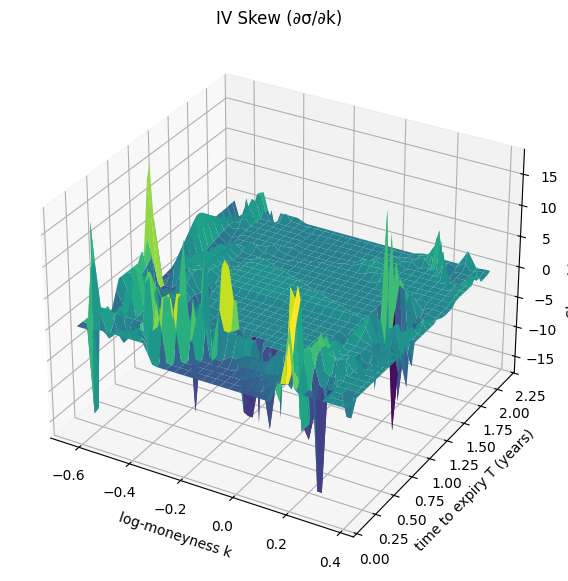

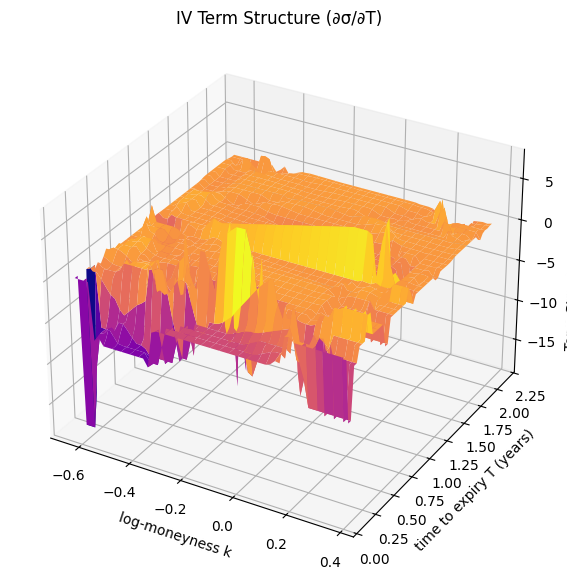

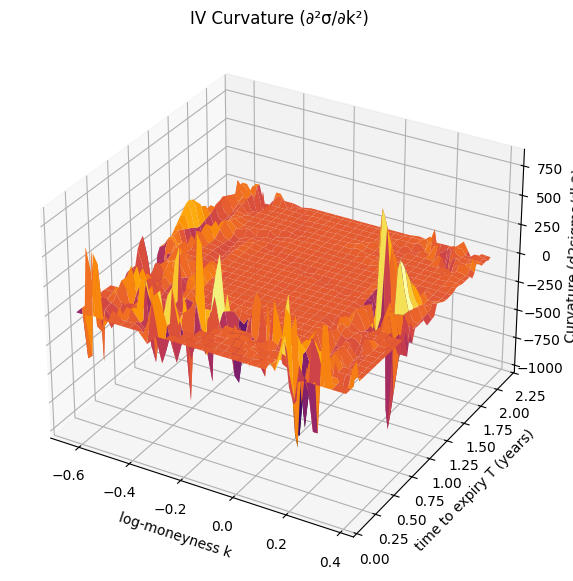

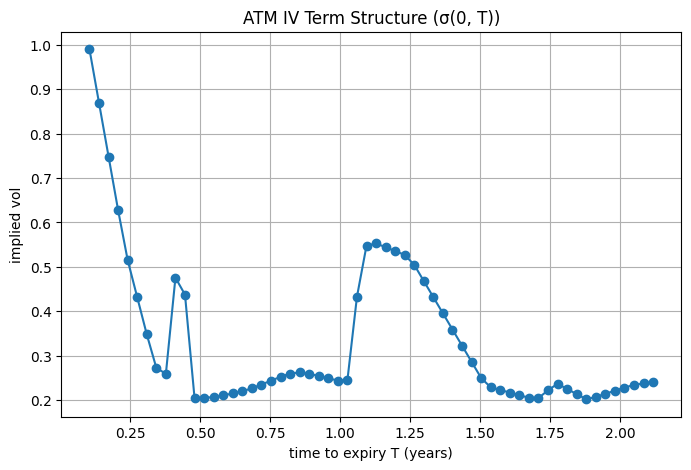

In [28]:
# --- Analyze the IV surface: Skew, Term Structure, Curvature ---

if KK is None or TT is None or IV is None:
    print("Surface grids (KK, TT, IV) not available. Run the previous cell first.")
else:
    # Calculate derivatives (finite differences)
    # Skew: d(sigma)/d(k)
    dsigma_dk = np.gradient(IV, axis=1) / np.gradient(KK, axis=1)

    # Term structure: d(sigma)/d(T)
    dsigma_dT = np.gradient(IV, axis=0) / np.gradient(TT, axis=0)

    # Curvature: d^2(sigma)/d(k)^2
    d2sigma_dk2 = np.gradient(dsigma_dk, axis=1) / np.gradient(KK, axis=1)

    # ATM Term Structure: sigma(k=0, T)
    # Find the index closest to k=0 for each T
    atm_iv = []
    atm_T = []
    for i in range(IV.shape[0]):
        k_row = KK[i, :]
        closest_k_idx = np.argmin(np.abs(k_row))
        atm_iv.append(IV[i, closest_k_idx])
        atm_T.append(TT[i, closest_k_idx])

    print("\n✅ Surface analysis complete.")

    # --- Visualization ---

    print("\n--- Visualizing Surface Derivatives ---")

    # Plot Skew (dsigma/dk)
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(KK, TT, dsigma_dk, cmap='viridis', linewidth=0, antialiased=True)
    ax.set_xlabel("log-moneyness k")
    ax.set_ylabel("time to expiry T (years)")
    ax.set_zlabel("Skew (dsigma/dk)")
    ax.set_title("IV Skew (∂σ/∂k)")
    plt.show()

    # Plot Term Structure (dsigma/dT)
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(KK, TT, dsigma_dT, cmap='plasma', linewidth=0, antialiased=True)
    ax.set_xlabel("log-moneyness k")
    ax.set_ylabel("time to expiry T (years)")
    ax.set_zlabel("Term Structure (dsigma/dT)")
    ax.set_title("IV Term Structure (∂σ/∂T)")
    plt.show()

    # Plot Curvature (d2sigma/dk2)
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(KK, TT, d2sigma_dk2, cmap='inferno', linewidth=0, antialiased=True)
    ax.set_xlabel("log-moneyness k")
    ax.set_ylabel("time to expiry T (years)")
    ax.set_zlabel("Curvature (d2sigma/dk2)")
    ax.set_title("IV Curvature (∂²σ/∂k²)")
    plt.show()

    # Plot ATM Term Structure (sigma(k=0, T))
    plt.figure(figsize=(8, 5))
    plt.plot(atm_T, atm_iv, marker='o')
    plt.xlabel("time to expiry T (years)")
    plt.ylabel("implied vol")
    plt.title("ATM IV Term Structure (σ(0, T))")
    plt.grid(True)
    plt.show()


Fitting SVI (Quasi-Explicit) for expiry 2026-01-16 (T=0.104y)...

SVI Params (a, b, rho, m, sigma): [4.62900e-02 1.07157e+00 5.30460e-01 1.54900e-01 1.00000e-04]


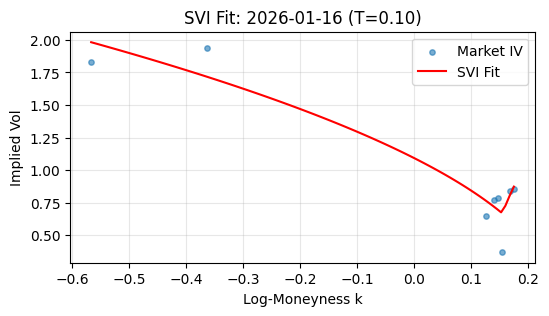


Fitting SVI (Quasi-Explicit) for expiry 2026-03-20 (T=0.277y)...

SVI Params (a, b, rho, m, sigma): [ 7.4270e-02  4.1360e-02 -8.1590e-01 -4.6371e-01  1.0000e-04]


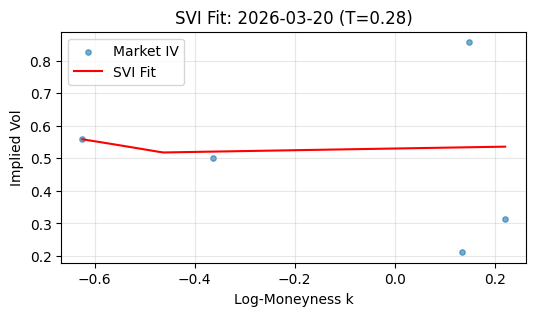


Fitting SVI (Quasi-Explicit) for expiry 2026-03-31 (T=0.307y)...

SVI Params (a, b, rho, m, sigma): [3.6100e-03 3.5446e-01 5.1986e-01 2.1789e-01 1.0000e-04]


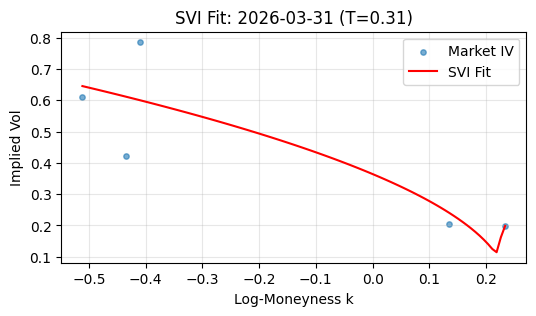


Fitting SVI (Quasi-Explicit) for expiry 2026-04-17 (T=0.353y)...

SVI Params (a, b, rho, m, sigma): [-0.15101  0.58624  0.2434  -0.06904  0.12177]


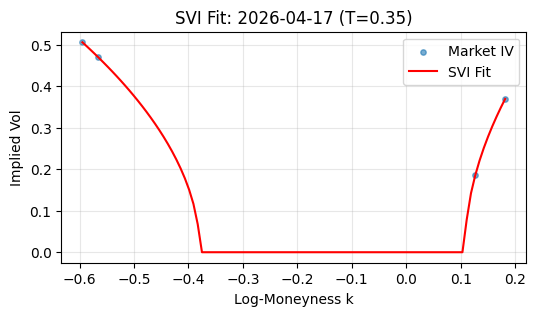


Fitting SVI (Quasi-Explicit) for expiry 2026-05-15 (T=0.430y)...

SVI Params (a, b, rho, m, sigma): [ 7.3050e-02  0.0000e+00 -9.9990e-01 -2.7513e-01  1.0000e-04]


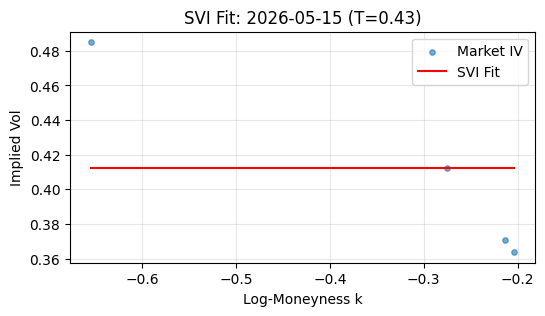


Fitting SVI (Quasi-Explicit) for expiry 2026-06-18 (T=0.523y)...

SVI Params (a, b, rho, m, sigma): [ 2.4942e-01  0.0000e+00  9.9990e-01 -2.9680e-01  1.0000e-04]


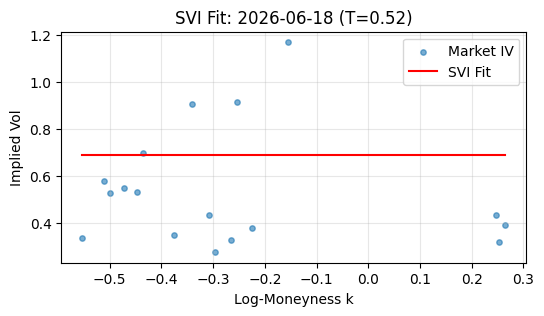


Fitting SVI (Quasi-Explicit) for expiry 2026-06-30 (T=0.556y)...

SVI Params (a, b, rho, m, sigma): [-6.27800000e-02  3.03722237e+03  9.99900000e-01  2.05530000e-01
  1.52000000e-03]


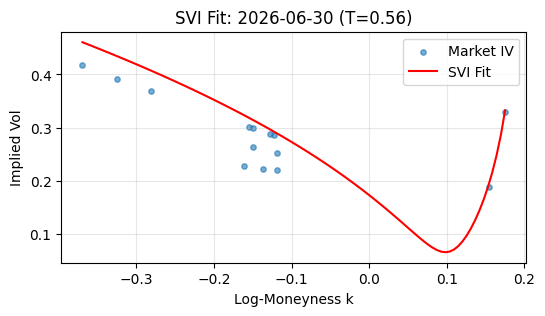


Fitting SVI (Quasi-Explicit) for expiry 2026-09-18 (T=0.775y)...

SVI Params (a, b, rho, m, sigma): [ 0.02474  0.38523 -0.9999  -0.32731  0.1595 ]


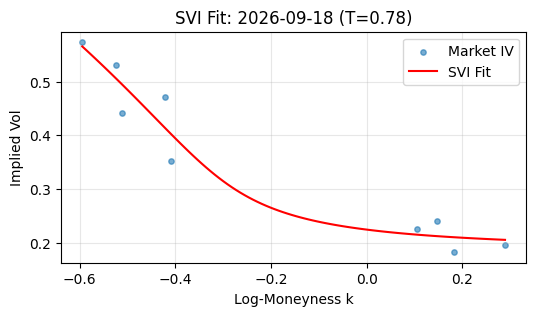


Fitting SVI (Quasi-Explicit) for expiry 2026-09-30 (T=0.808y)...

SVI Params (a, b, rho, m, sigma): [-1.4156   0.72329  0.06701  0.40152  2.     ]


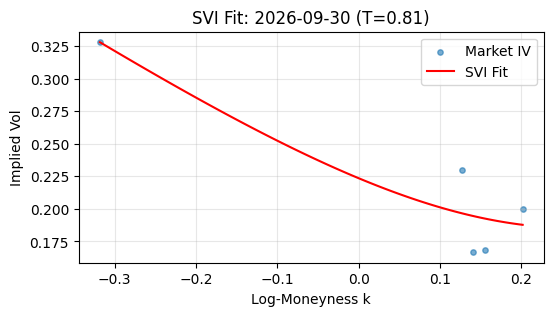


Fitting SVI (Quasi-Explicit) for expiry 2026-12-18 (T=1.025y)...

SVI Params (a, b, rho, m, sigma): [-1.75617  4.96615  0.69405  0.43368  0.46946]


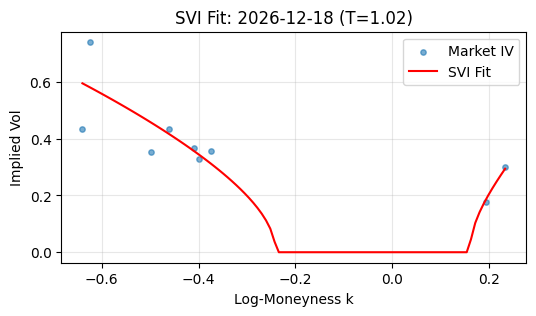


Fitting SVI (Quasi-Explicit) for expiry 2027-01-15 (T=1.101y)...

SVI Params (a, b, rho, m, sigma): [ 1.40420e-01  1.16639e+00 -7.63710e-01 -6.03790e-01  1.00000e-04]


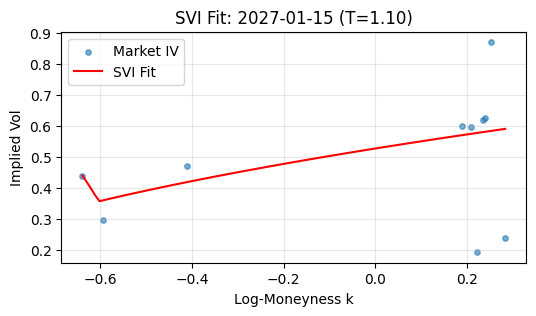


Fitting SVI (Quasi-Explicit) for expiry 2027-06-17 (T=1.521y)...

SVI Params (a, b, rho, m, sigma): [ 4.9940e-02  3.8805e-01 -9.2387e-01 -1.5155e-01  4.1000e-04]


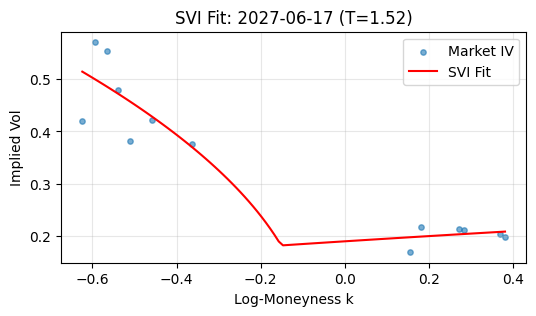


Fitting SVI (Quasi-Explicit) for expiry 2027-09-17 (T=1.773y)...

SVI Params (a, b, rho, m, sigma): [-9.44600000e-02  1.14794787e+07 -9.99900000e-01 -4.61840000e-01
  1.00000000e-04]


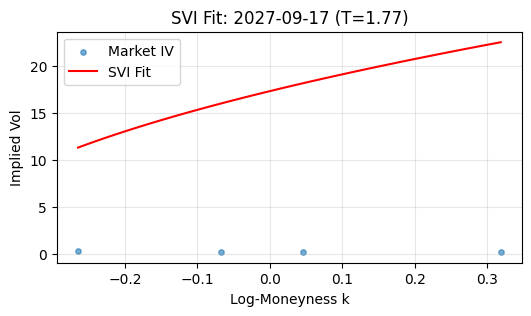


Fitting SVI (Quasi-Explicit) for expiry 2027-12-17 (T=2.022y)...

SVI Params (a, b, rho, m, sigma): [ 4.6850e-02  5.1797e-01 -4.9052e-01 -4.7480e-02  1.0000e-04]


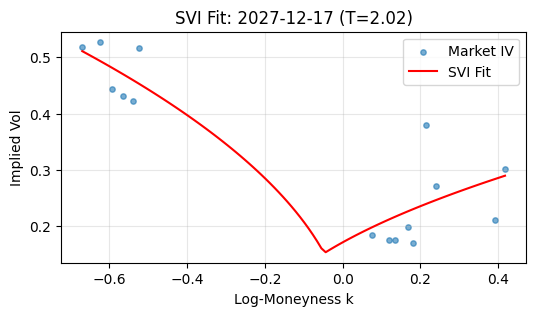


Fitting SVI (Quasi-Explicit) for expiry 2028-01-21 (T=2.118y)...

SVI Params (a, b, rho, m, sigma): [-0.91878  4.34256  0.71354  0.52987  0.31869]


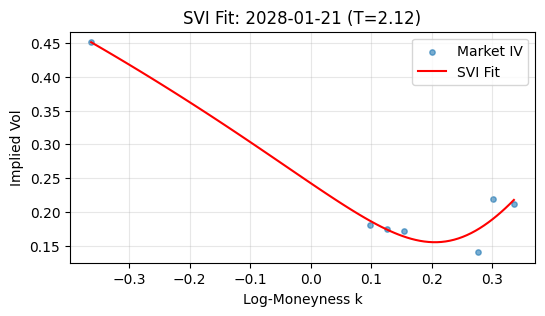


✅ Quasi-Explicit SVI calibration complete.


In [33]:
from scipy.optimize import minimize

# Standard Raw SVI formula: w(k) = a + b * (rho*(k-m) + sqrt((k-m)^2 + sigma^2))
def svi_raw_variance(k, a, b, rho, m, sigma):
    return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))

def svi_vol(k, T, a, b, rho, m, sigma):
    w = svi_raw_variance(k, a, b, rho, m, sigma)
    w = np.maximum(1e-9, w) # Ensure non-negative variance
    return np.sqrt(w / T)

def fit_svi_quasi_explicit(df_expiry):
    """
    Fits SVI model using Quasi-Explicit method (Zeliade).
    Outer loop optimizes (m, sigma), inner step solves linear least squares for (a, b, rho).
    """
    if df_expiry.empty: return None, None

    k = df_expiry["k"].values
    T = df_expiry["T"].iloc[0]
    iv_market = df_expiry["iv_clean"].values
    w_market = (iv_market ** 2) * T

    # Bounds for outer optimization
    # m: usually around ATM. Let's allow it to be within reasonable moneyness range.
    m_bounds = (k.min() - 0.2, k.max() + 0.2)
    sigma_bounds = (1e-4, 2.0) # sigma > 0

    def outer_objective(params):
        m, sigma = params
        y = k - m
        sqrt_term = np.sqrt(y**2 + sigma**2)

        # Design matrix for linear system: w = a + c*y + d*sqrt_term
        # where c = b*rho, d = b
        # Regress w_market against [1, y, sqrt_term]
        X = np.column_stack([np.ones_like(y), y, sqrt_term])

        # Linear Least Squares
        # We want to minimize sum((w_model - w_market)^2)
        # subject to constraints implicitly.
        try:
            beta, residuals, rank, s = np.linalg.lstsq(X, w_market, rcond=None)
            a_ols, c_ols, d_ols = beta
        except Exception:
             return 1e10

        # Recover SVI params to check constraints
        # b = d
        # rho = c / b

        penalty = 0.0
        # Constraint: b >= 0
        if d_ols < 0:
            penalty += 1e5 * (abs(d_ols) + 1e-4)**2

        # Constraint: |rho| <= 1  => |c| <= b  (assuming b>=0)
        # If b < 0, this check is less meaningful, but handled by penalty above.
        if d_ols > 0:
            if abs(c_ols) > d_ols:
                penalty += 1e5 * (abs(c_ols) - d_ols + 1e-4)**2

        # Additional regularization or constraints can be added here

        # Calculate RSS
        w_model = X @ beta
        rss = np.sum((w_model - w_market)**2)

        return rss + penalty

    # Initial guess: m=0 (ATM), sigma=0.1
    x0 = [0.0, 0.1]

    try:
        res = minimize(outer_objective, x0, bounds=[m_bounds, sigma_bounds], method='L-BFGS-B')

        # Handle message type (bytes vs str) for different scipy versions
        msg = res.message
        if isinstance(msg, bytes):
            msg = msg.decode('ascii')

        if res.success or (not msg.startswith('ABNORMAL_TERMINATION_IN_LNSRCH')):
            m_opt, sigma_opt = res.x

            # Re-compute best linear params
            y = k - m_opt
            sqrt_term = np.sqrt(y**2 + sigma_opt**2)
            X = np.column_stack([np.ones_like(y), y, sqrt_term])
            beta, _, _, _ = np.linalg.lstsq(X, w_market, rcond=None)
            a, c, d = beta

            # Enforce constraints strictly for final parameters
            b = max(1e-9, d)
            rho = c / b
            rho = np.clip(rho, -0.9999, 0.9999)

            params = np.array([a, b, rho, m_opt, sigma_opt])

            # Calculate fitted vols for plotting
            fitted_vols = svi_vol(k, T, *params)
            return params, fitted_vols
        else:
            print(f"Optimization failed for T={T:.3f}: {msg}")
            return None, None

    except Exception as e:
        print(f"Error fitting T={T:.3f}: {e}")
        return None, None

# --- Main Loop ---
if 'CLEAN' not in globals() or CLEAN.empty:
    print("CLEAN DataFrame not found or is empty.")
else:
    CLEAN['expiry'] = pd.to_datetime(CLEAN['expiry'])
    svi_fits = {}

    for expiry, df_expiry in CLEAN.groupby("expiry"):
        T = df_expiry["T"].iloc[0]
        print(f"\nFitting SVI (Quasi-Explicit) for expiry {expiry.date()} (T={T:.3f}y)...\n")

        svi_params, svi_fitted_vols = fit_svi_quasi_explicit(df_expiry)

        if svi_params is not None:
            svi_fits[expiry] = {
                "params": svi_params,
                "fitted_vols": svi_fitted_vols,
                "k": df_expiry["k"].values,
                "actual_vols": df_expiry["iv_clean"].values
            }
            print("SVI Params (a, b, rho, m, sigma):", np.round(svi_params, 5))

            # Visualization
            plt.figure(figsize=(6, 3))
            plt.scatter(df_expiry["k"], df_expiry["iv_clean"], label="Market IV", alpha=0.6, s=15)

            # Smooth curve
            k_smooth = np.linspace(df_expiry["k"].min(), df_expiry["k"].max(), 100)
            vols_smooth = svi_vol(k_smooth, T, *svi_params)

            plt.plot(k_smooth, vols_smooth, color='red', label='SVI Fit')
            plt.xlabel("Log-Moneyness k")
            plt.ylabel("Implied Vol")
            plt.title(f"SVI Fit: {expiry.date()} (T={T:.2f})")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
        else:
            print("Skipping expiry due to fit failure.")

    print("\n✅ Quasi-Explicit SVI calibration complete.")

In [30]:
expiries = sorted(df_expiry['expiry'])

In [34]:
def svi_w(k, a,b,rho,m,sigma):
    return a + b*(rho*(k-m) + np.sqrt((k-m)**2 + sigma**2))

def svi_wprime(k, b,rho,m,sigma):
    return b*(rho + (k-m)/np.sqrt((k-m)**2 + sigma**2))

def svi_wpp(k, b,m,sigma):
    return b*(sigma**2)/(((k-m)**2 + sigma**2)**1.5)

def atm_metrics_from_row(params, T):
    """params = [a,b,rho,m,sig], returns (ATM_IV, ATM_skew, ATM_curv) at k=0"""
    a,b,rho,m,sigma = params
    k0 = 0.0

    w0  = svi_w(k0, a,b,rho,m,sigma)
    wp  = svi_wprime(k0, b,rho,m,sigma)
    wpp = svi_wpp(k0, b,m,sigma)

    # Ensure positive variance and T to avoid division by zero or sqrt of negative
    w0_safe = max(w0, 1e-9)
    T_safe = max(T, 1e-6)

    iv_atm   = np.sqrt(w0_safe / T_safe)
    skew_atm = 0.5 * wp / np.sqrt(w0_safe * T_safe)

    # Curvature calculation
    # d2sigma/dk2 = 1/sqrt(T) * ( w''/(2sqrt(w)) - w'²/(4w^(3/2)) )
    term1 = wpp / (2 * np.sqrt(w0_safe))
    term2 = (wp**2) / (4 * (w0_safe * np.sqrt(w0_safe)))
    curv_atm = (term1 - term2) / np.sqrt(T_safe)

    return float(iv_atm), float(skew_atm), float(curv_atm)

In [37]:
rows = []
asof_value = CLEAN['asof'].iloc[0]
# sort the expiries
expiry_order = sorted(svi_fits.keys())

for i, exp in enumerate(expiry_order):
    # Retrieve the stored SVI data for this specific expiry
    exp_data = svi_fits[exp]
    params = exp_data["params"] # This is the array/tuple [a,b,rho,m,sigma]

    # Get T for the current expiry (exp) from the original CLEAN DataFrame
    try:
        T_series = CLEAN.loc[CLEAN['expiry'] == exp, 'T']
        if not T_series.empty:
            T = T_series.iloc[0]
        else:
            print(f"Warning: Expiry {exp} from svi_fits not found in CLEAN DataFrame to get 'T'. Skipping.")
            continue
    except NameError:
        print("Error: CLEAN DataFrame not found in current scope. Cannot retrieve 'T'.")
        print("Please ensure the 'CLEAN' DataFrame is loaded and accessible.")
        break
    iv_atm, skew_atm, curv_atm = atm_metrics_from_row(params, T)
    a, b, rho, m, sigma = params

    rows.append({
        'asof':asof_value,
        'expiry': exp,
        'T': T,
        'ATM_IV': iv_atm,
        'ATM_skew': skew_atm,
        'ATM_curvature': curv_atm,
        'a': a,
        'b': b,
        'rho': rho,
        'm': m,
        'sigma': sigma
    })

metrics = pd.DataFrame(rows).sort_values(['asof', 'T']).reset_index(drop=True)
METRICS_DIR = '/content/drive/MyDrive/Colab Notebooks/VolSurf_ML/metrics'
os.makedirs(METRICS_DIR, exist_ok=True)

asof_date = pd.to_datetime(asof_value).date()
metrics_path = os.path.join(METRICS_DIR, f'svi_metrics_{asof_date}.parquet')

metrics.to_parquet(metrics_path, index=False)
print(f"Saved SVI metrics to {metrics_path}")
print("SVI Metrics DataFrame head:")
print(metrics.head())

Saved SVI metrics to /content/drive/MyDrive/Colab Notebooks/VolSurf_ML/metrics/svi_metrics_2025-12-09.parquet
SVI Metrics DataFrame head:
        asof     expiry         T    ATM_IV      ATM_skew  ATM_curvature  \
0 2025-12-09 2026-01-16  0.104110  1.092347 -2.212118e+00  -4.479759e+00   
1 2025-12-09 2026-03-20  0.276712  0.530245  2.594719e-02  -1.269696e-03   
2 2025-12-09 2026-03-31  0.306849  0.364181 -7.614831e-01  -1.592218e+00   
3 2025-12-09 2026-04-17  0.353425  0.000053  1.148455e+04  -2.479572e+12   
4 2025-12-09 2026-05-15  0.430137  0.412109  2.818797e-13   1.354307e-15   

          a             b       rho         m     sigma  
0  0.046290  1.071568e+00  0.530463  0.154899  0.000100  
1  0.074269  4.135815e-02 -0.815896 -0.463713  0.000100  
2  0.003615  3.544587e-01  0.519860  0.217885  0.000100  
3 -0.151012  5.862403e-01  0.243398 -0.069036  0.121775  
4  0.073052  1.000000e-09 -0.999900 -0.275134  0.000100  


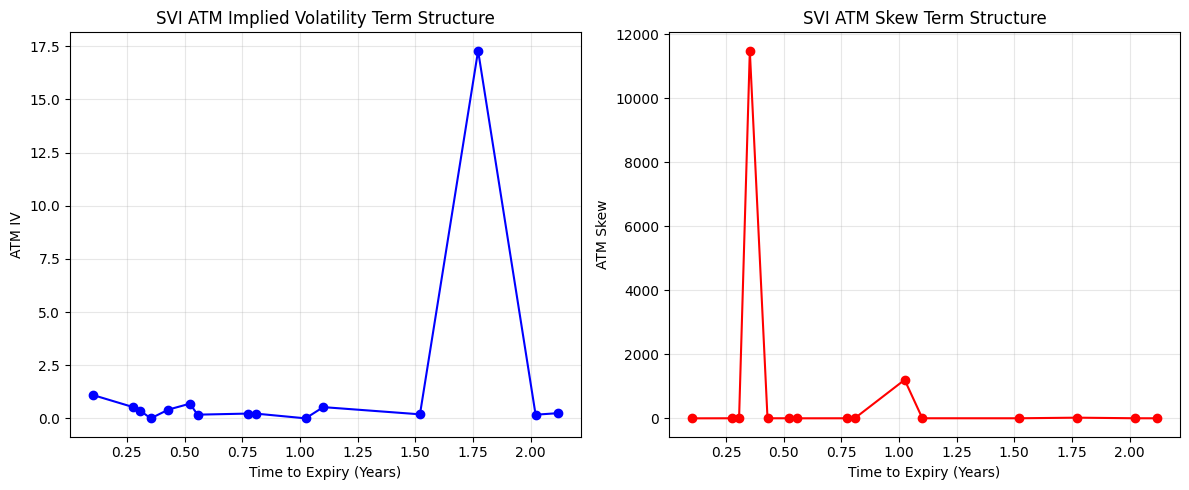

In [38]:
# --- Visualization of SVI ATM Metrics ---
if 'metrics' in globals():
    plt.figure(figsize=(12, 5))

    # Plot ATM IV Term Structure
    plt.subplot(1, 2, 1)
    plt.plot(metrics['T'], metrics['ATM_IV'], marker='o', linestyle='-', color='b')
    plt.title("SVI ATM Implied Volatility Term Structure")
    plt.xlabel("Time to Expiry (Years)")
    plt.ylabel("ATM IV")
    plt.grid(True, alpha=0.3)

    # Plot ATM Skew Term Structure
    plt.subplot(1, 2, 2)
    plt.plot(metrics['T'], metrics['ATM_skew'], marker='o', linestyle='-', color='r')
    plt.title("SVI ATM Skew Term Structure")
    plt.xlabel("Time to Expiry (Years)")
    plt.ylabel("ATM Skew")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("Metrics DataFrame not found.")